# Volume 3: Gibbs Sampling and LDA
    Samuel Goldrup
    Math 405
    31 January 2023

In [1]:
import numpy as np
from scipy.special import gammaln
from math import sqrt
from scipy.stats import norm, invgamma, gaussian_kde
import matplotlib
matplotlib.use('nbAgg')
from matplotlib import pyplot as plt

## Problem 1

Implement a Gibbs sampler for the exam scores problem (using the data in `examscores.npy`).
Test your sampler with priors $\nu=80$, $\tau^{2} = 16$, $\alpha = 3$, and $\beta = 50$, collecting $1000$ samples.
Plot your samples of $\mu$ and your samples of $\sigma^{2}$.

In [2]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """ Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    x_s = np.empty((n_samples,2))
    mu = norm.rvs(nu,scale=sqrt(tau2))
    s2 = invgamma.rvs(alpha,scale=beta) #initialize starting parameters
    N = len(y)
    
    for k in range(n_samples):
        s2_st = 1/(1/tau2 + N/s2) #update parameters
        mu_st = s2_st*(nu/tau2 + (1/s2)*np.sum(y))
        alpha_st = alpha + N/2
        beta_st = beta + (1/2)*np.sum((y-mu)**2)
        
        mu = norm.rvs(mu_st,scale=sqrt(s2_st)) # we will converge to correct  mu,sigma
        s2 = invgamma.rvs(alpha_st,scale=beta_st)
        
            
        x_s[k] = np.array([mu,s2])
        
    return x_s

<IPython.core.display.Javascript object>


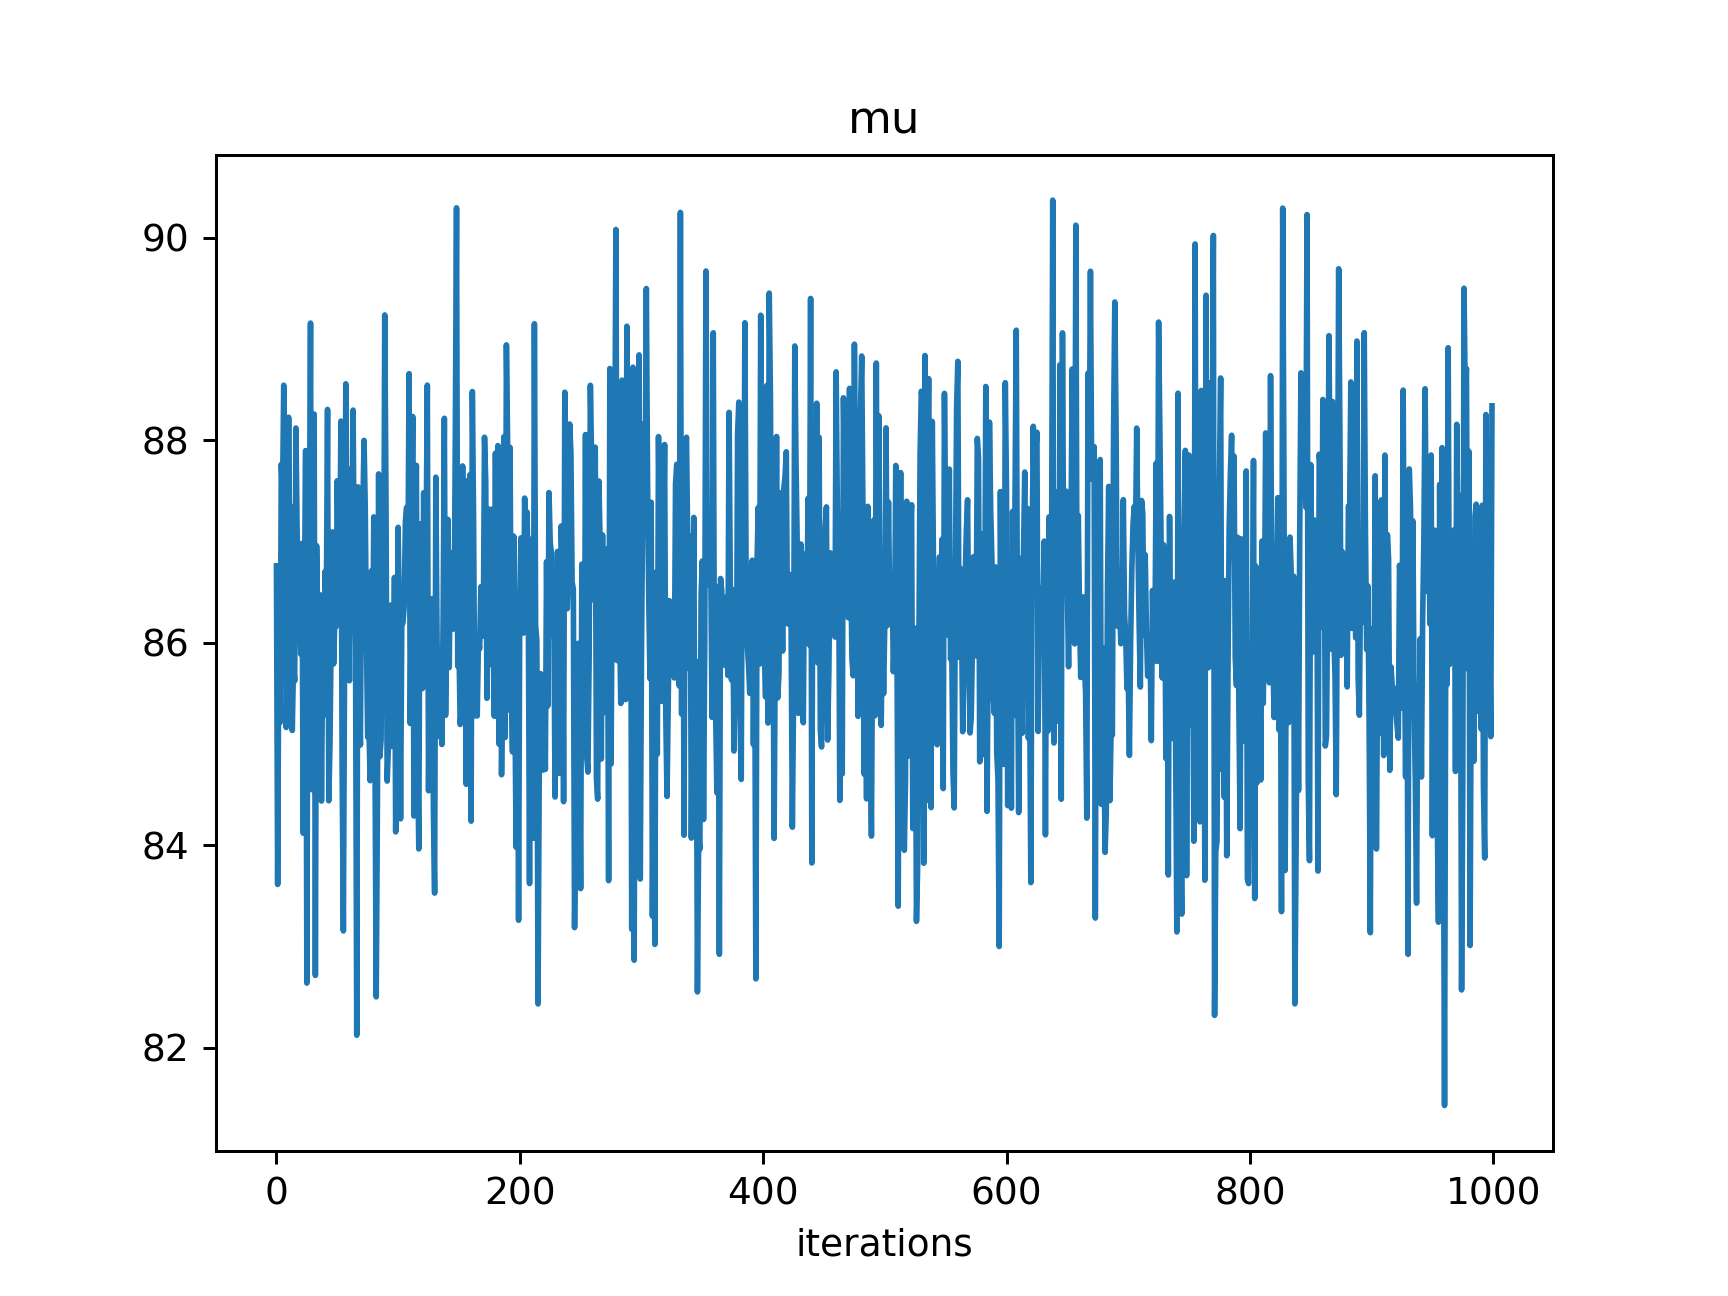

<IPython.core.display.Javascript object>


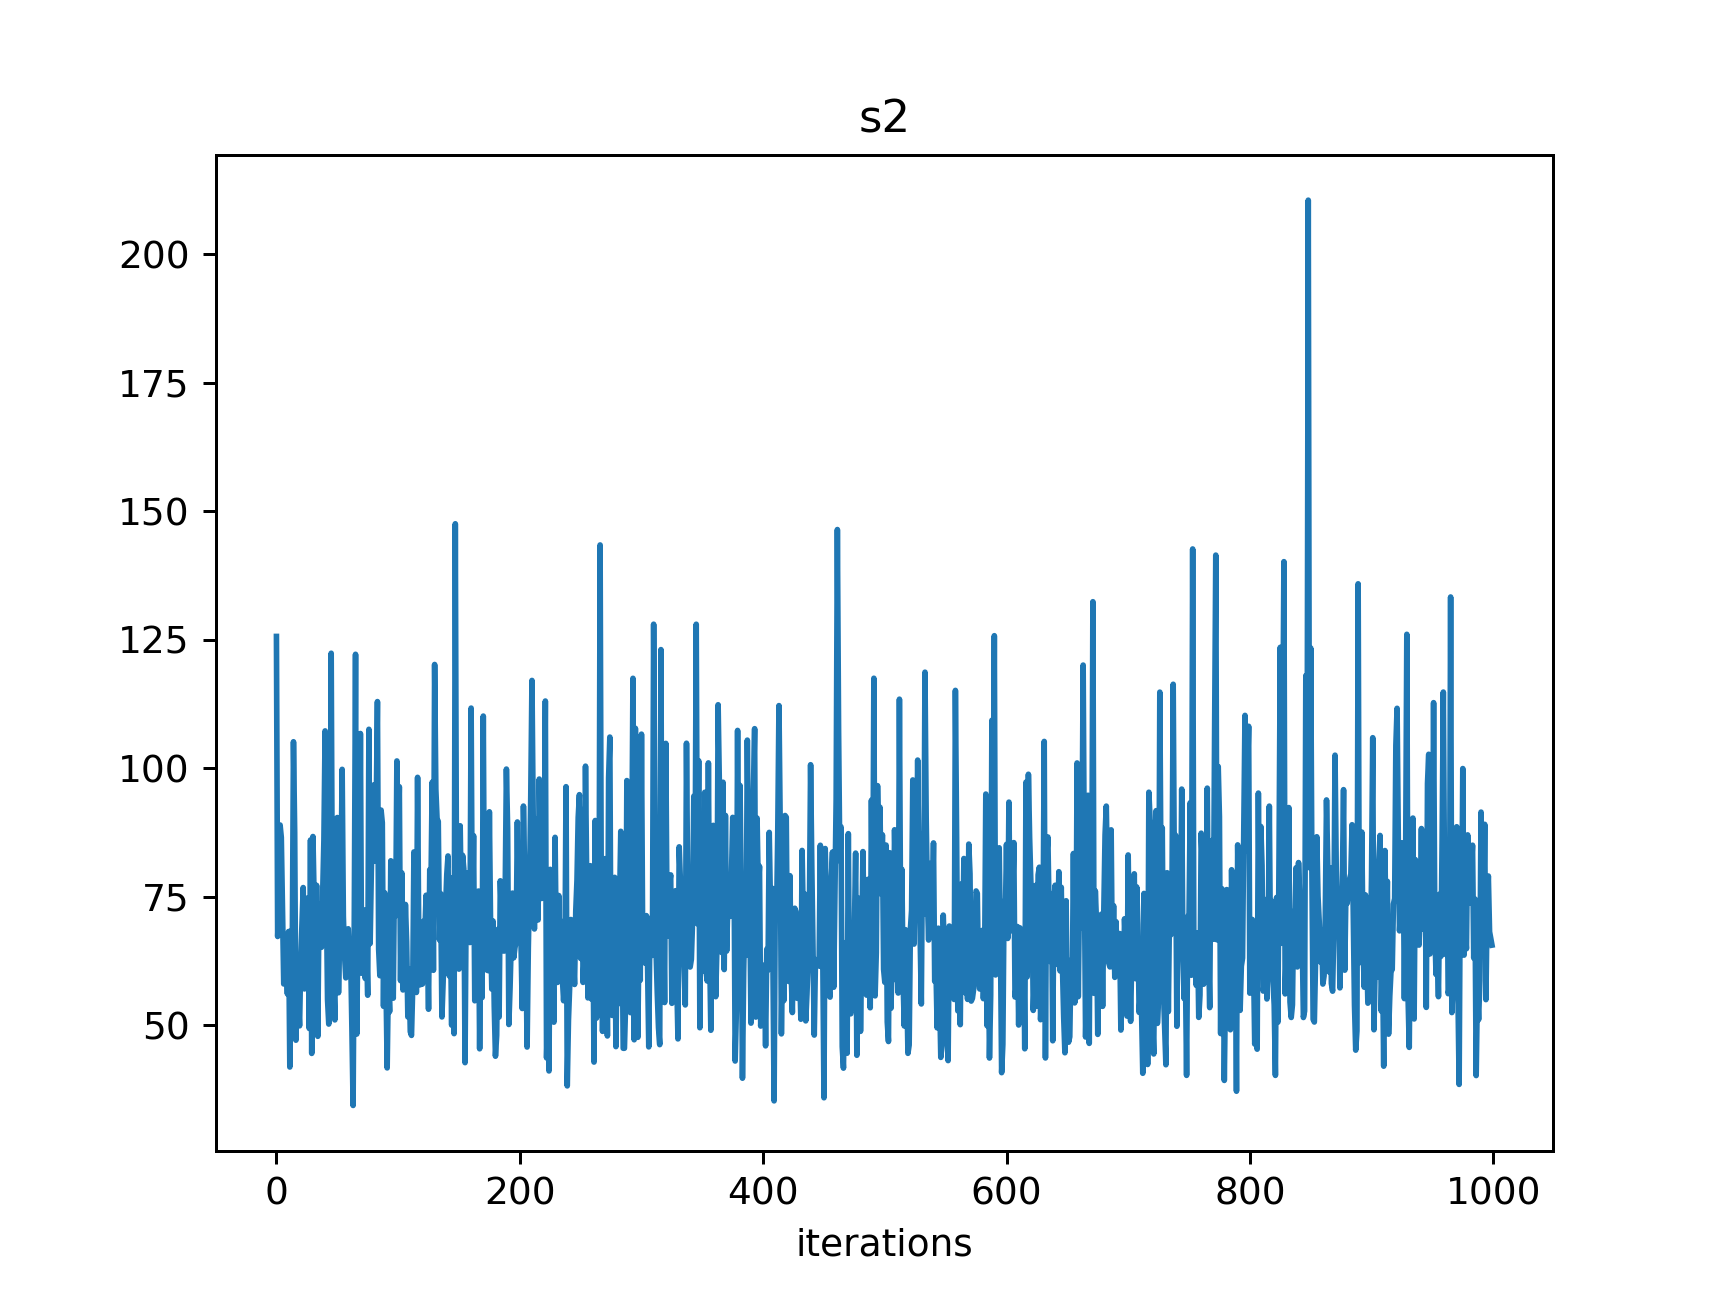

In [3]:
nu,tau_sq,alpha,beta,n_samples = 80.,16.,3.,50.,1000
y = np.load('examscores.npy')
x_s = gibbs(y, nu, tau_sq, alpha, beta, n_samples)


plt.plot(x_s[:,0]) #mu
plt.title("mu")
plt.xlabel("iterations")
plt.show()
plt.plot(x_s[:,1]) #s2
plt.title("s2")
plt.xlabel("iterations")
plt.show()

## Problem 2

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

<IPython.core.display.Javascript object>


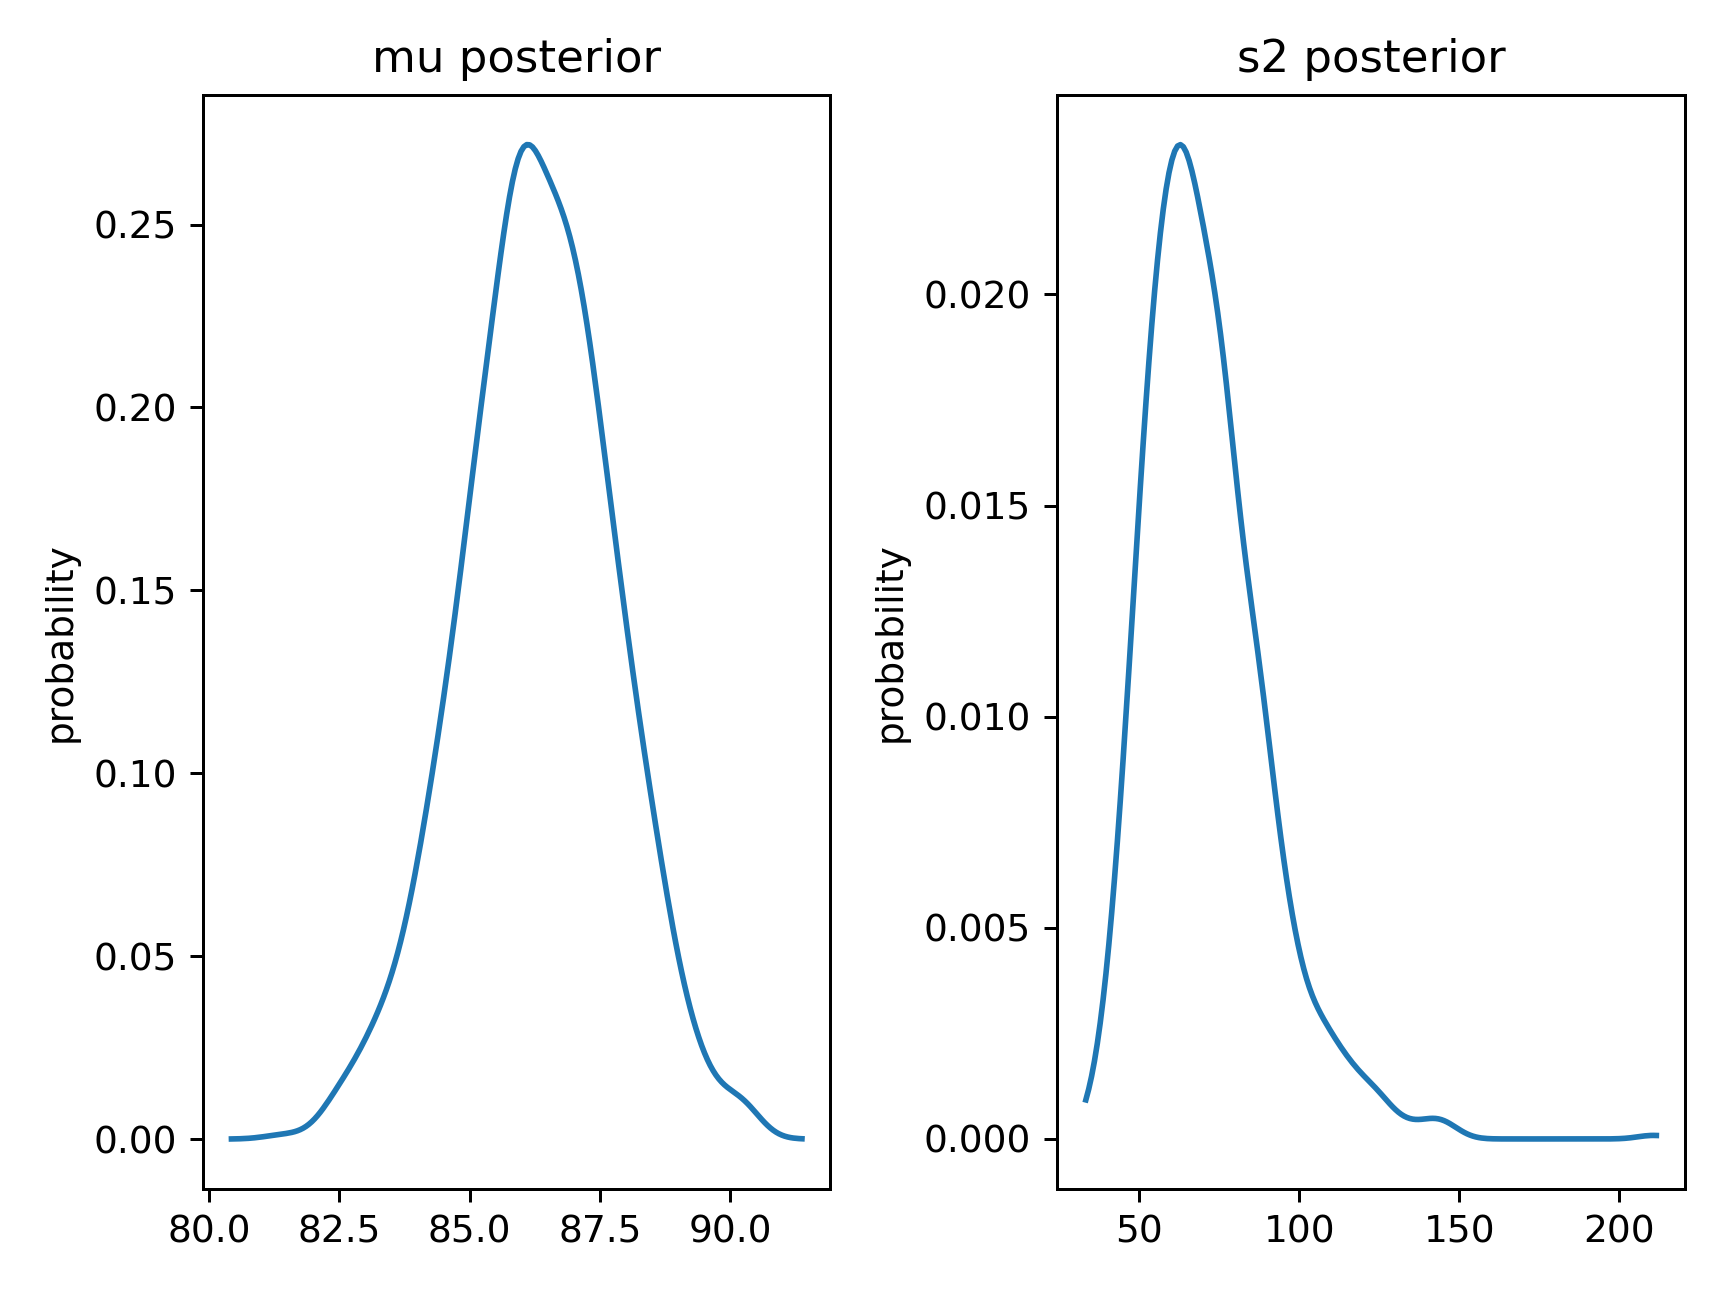

<IPython.core.display.Javascript object>


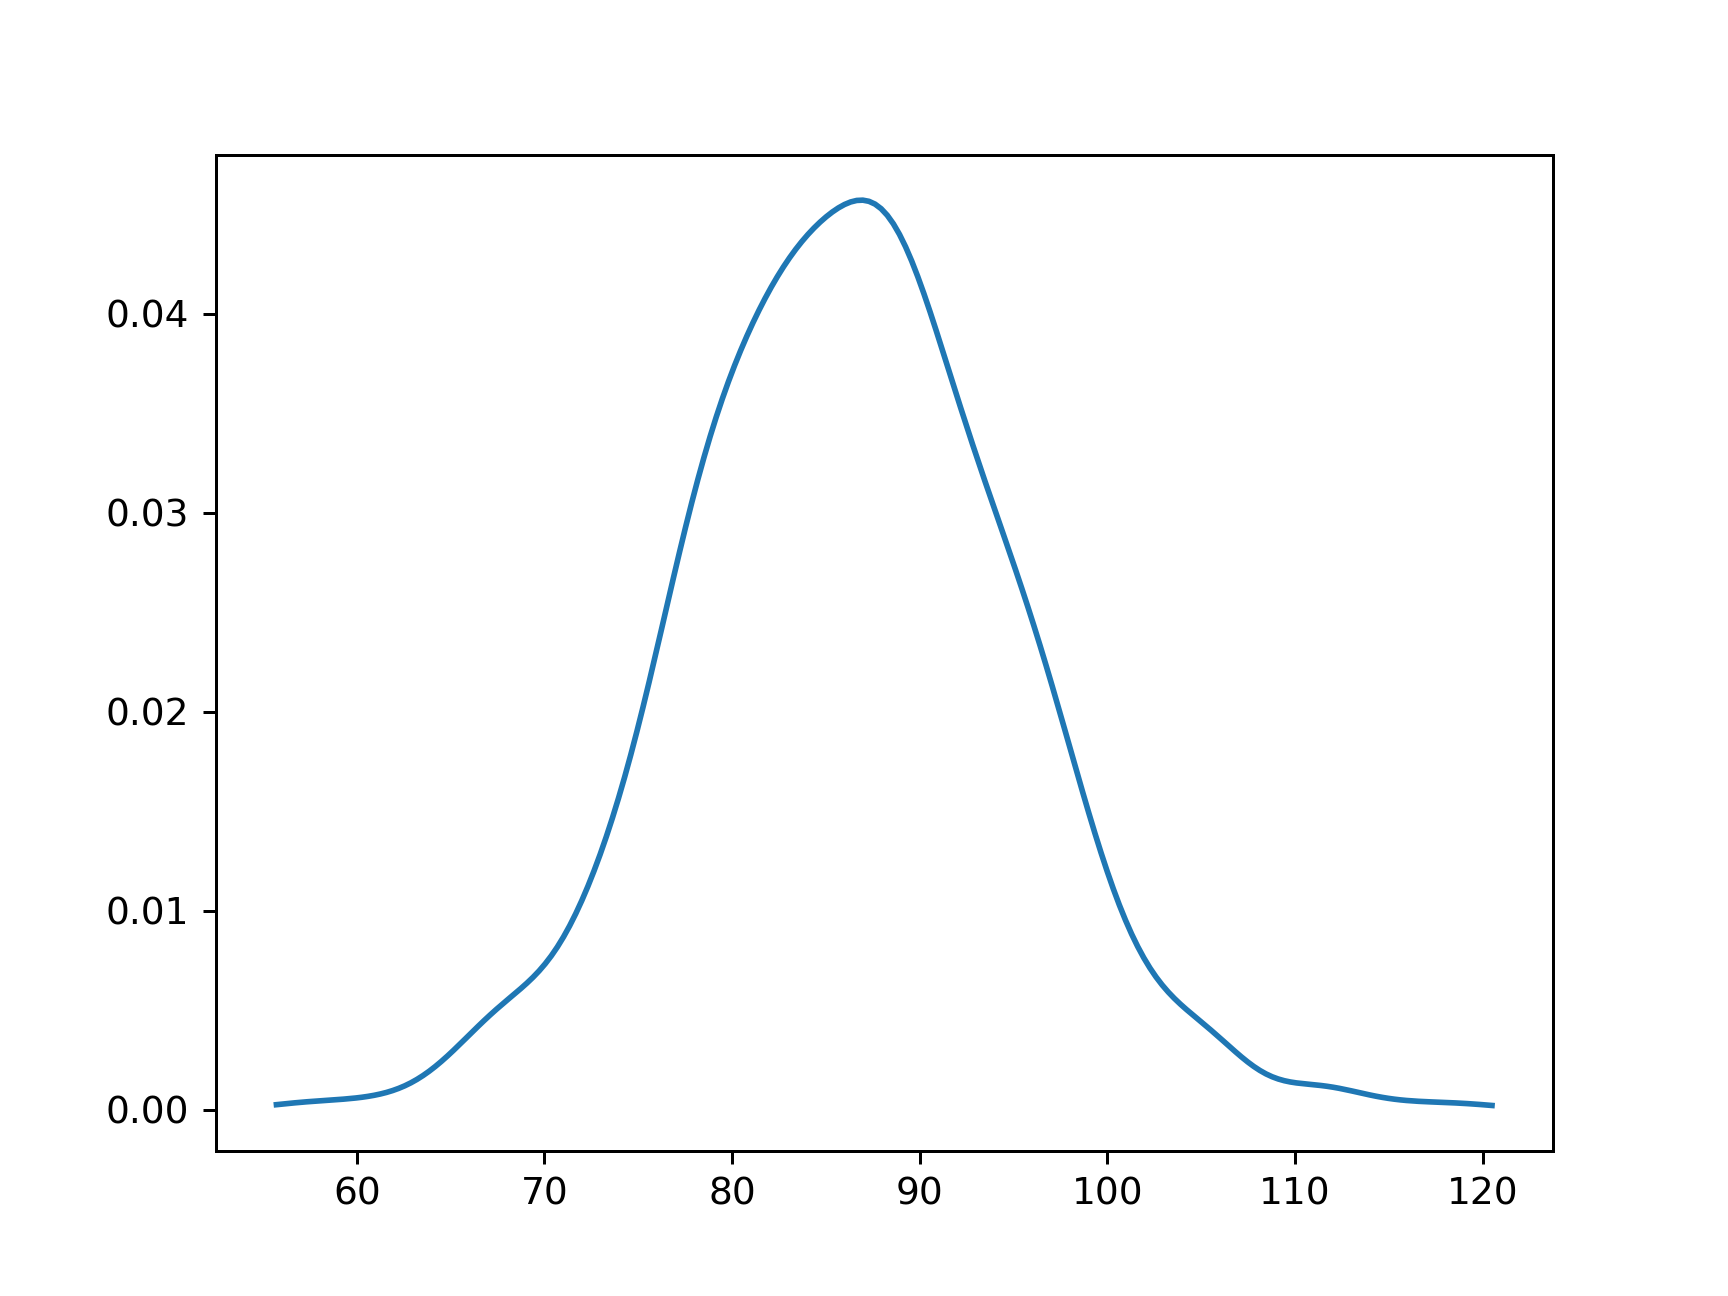

In [4]:
mu_samples, s2_samples = x_s[:,0], x_s[:,1]
mu_kernel = gaussian_kde(mu_samples) #run KDE
x_mu = np.linspace(min(mu_samples)-1, max(mu_samples)+1,200) #build linspaces
x_s2 = np.linspace(min(s2_samples)-1,max(s2_samples)+1,200)
s2_kernel = gaussian_kde(s2_samples) #run KDE

plt.subplots()
plt.subplot(121).plot(x_mu,mu_kernel(x_mu))
plt.title("mu posterior")
plt.ylabel("probability")
plt.subplot(122).plot(x_s2,s2_kernel(x_s2))
plt.title("s2 posterior")
plt.ylabel("probability")
plt.tight_layout()
plt.show()

mu, s2 = mu_samples[-1], s2_samples[-1]
score_draws = [np.random.normal(x[0],scale=sqrt(x[1])) for x in x_s]
x_score = np.linspace(min(score_draws)-1,max(score_draws)+1,200)
score_kernel = gaussian_kde(score_draws)
plt.plot(x_score,score_kernel(x_score))
plt.show()

## Problem 3

Complete the method `LDACGS.initialize()`.



## Problem 4

Complete the method `LDACGS._sweep()`.



## Problem 5

Complete the method `LDACGS.sample()`.


In [5]:
class LDACGS:
    """ Do LDA with Gibbs Sampling. """

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """ Initializes attributes n_topics, alpha, and beta. """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta


    def buildCorpus(self, filename, stopwords_file=None):
        """ Reads the given filename, and using any provided stopwords,
            initializes attributes vocab and documents. 
            
            Vocab is a list of terms found in filename.
            
            Documents is a list of dictionaries (a dictionary for each 
            document); for dictionary m in documents, each entry is of 
            the form n:w, where w is the index in vocab of the nth word 
            in document m.
        """
        with open(filename, 'r') as infile:  # create vocab
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        
        if stopwords_file:   # if there are stopwords, remove them from vocab
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        
        self.documents = []  # create documents
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

                    
    def initialize(self):
        """ Initializes attributes n_words, n_docs, the three count matrices, 
            and topics.
                        
            Note that
            n_topics = K, the number of possible topics
            n_docs   = M, the number of documents being analyzed
            n_words  = V, the number of words in the vocabulary
            
            To do this, you will need to initialize nkm, nkv, and nk 
            to be zero arrays of the correct size.
            Matrix nkm corresponds to n_(k,m,.)
            Matrix nkv corresponds to n_(k,.,v)
            Matrix nk corresponds to n_(k,.,.)
            You will then iterate through each word found in each document.
            In the second of these for-loops (for each word), you will 
            randomly assign z as an integer from the range of topics.
            Then, you will increment each of the count matrices by 1, 
            given the values for z, m, and w, where w is the index in 
            vocab of the nth word in document m.
            Finally, assign topics as given.
        """
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        
        # Initialize the three count matrices.
        # The (k, m) entry of self.nkm is the number of words in document m assigned to topic k.
        self.nkm = np.zeros((self.n_topics, self.n_docs))
        # The (k, v) entry of self.nkv is the number of times term v is assigned to topic k.
        self.nkv = np.zeros((self.n_topics, self.n_words))
        # The (k)-th entry of self.nk is the number of times topic k is assigned in the corpus.
        self.nk = np.zeros(self.n_topics)
        
        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z
        
        random_distribution = np.ones(self.n_topics) / self.n_topics #draw from this prior
        for m in range(self.n_docs):
            for i in self.documents[m]:
                z = np.random.randint(1,high=self.n_topics)
                self.nkm[z,m] += 1 #increment
                w = self.documents[m][i]
                self.nkv[z,w] += 1
                self.nk[z] += 1
                self.topics[(m,i)] = z
                
                
    def _sweep(self):
        """ Iterates through each word of each document, giving a better
            topic assignment for each word.
            
            To do this, iterate through each word of each document. 
            The first part of this method will undo what initialize() did
            by decrementing each of the count matrices by 1.
            Then, call the method _conditional() to use the conditional 
            distribution (instead of the uniform distribution used 
            previously) to pick a more accurate topic assignment z.
            Finally, repeat what initialize() did by incrementing each of
            the count matrices by 1, but this time using the more 
            accurate topic assignment.
        """
        for m in range(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i-th word in document m.
                w = self.documents[m][i]
                # Retrieve topic assignment for i-th word in document m.
                z = self.topics[(m,i)]
                # Decrement count matrices.
                self.nk[z] -= 1
                self.nkv[z,w] -= 1
                self.nkm[z,m] -= 1
                # Get conditional distribution.
                cond_dist = self._conditional(m,w)
                # Sample new topic assignment.
                z = np.argmax(np.random.binomial(1,cond_dist))
                # Increment count matrices.
                self.nkm[z,m] += 1
                w = self.documents[m][i]
                self.nkv[z,w] += 1
                self.nk[z] += 1
                self.topics[(m,i)] = z

                
    def sample(self, filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        """ Runs the Gibbs sampler on the given filename. 
        
            The argument filename is the name and location of a .txt 
            file, where each line is considered a document.
            The corpus is built by method buildCorpus(), and 
            stopwords are removed (if argument stopwords is provided).
            
            Initialize attributes total_nkm, total_nkv, and logprobs as
            zero arrays.
            total_nkm and total_nkv will be the sums of every 
            sample_rate-th nkm and nkv matrix respectively.
            logprobs is of length burnin + sample_rate * n_samples
            and will store each log-likelihood after each sweep of 
            the sampler.
            
            Burn-in the Gibbs sampler.
            
            After the burn-in, iterate further for n_samples iterations, 
            adding nkm and nkv to total_nkm and total_nkv respectively, 
            but only for every sample_rate-th iteration.
            
            Also, compute and save the log-likelihood at each iteration 
            in logprobs using the method _loglikelihood().
        """
        self.buildCorpus(filename, stopwords_file)
        self.initialize()
        
        self.total_nkm = np.zeros((self.n_topics, self.n_docs)) #had to change these, thanks Maxwell for the help
        self.total_nkv = np.zeros((self.n_topics, self.n_words))
        self.logprobs = np.zeros(burnin + sample_rate * n_samples)
        
        for i in range(burnin):
            self._sweep()
            llkhd = self._loglikelihood() #llkhd = loglikelihood
            self.logprobs[i] = llkhd # Sweep and store log likelihood.
        for i in range(sample_rate * n_samples):
            # Sweep and store log likelihood
            self._sweep()
            llkhd = self._loglikelihood()
            self.logprobs[burnin + i] = llkhd
            if not i % sample_rate: #every sample_rate-th iteration
                self.total_nkm += np.copy(self.nkm)
                self.total_nkv += np.copy(self.nkv)

                
    def _conditional(self, m, w):
        """ Returns the conditional distribution given m and w.
            Called by _sweep(). """
        dist = (self.nkm[:,m] + self.alpha) * (self.nkv[:,w] + self.beta) / (self.nk + self.beta * self.n_words)
        return dist / np.sum(dist)

    def _loglikelihood(self):
        """ Computes and returns the log-likelihood. Called by sample(). """
        lik = 0

        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nkv[z,:] + self.beta)) - gammaln(np.sum(self.nkv[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words * self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nkm[:,m] + self.alpha)) - gammaln(np.sum(self.nkm[:,m] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics * self.alpha)

        return lik
    
    def phi(self):
        """ Initializes attribute _phi. Called by topterms(). """
        phi = self.total_nkv + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        """ Initializes attribute _theta. Called by topterms. """
        theta = self.total_nkm + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self, n_terms=10):
        """ Returns the top n_terms of each topic found. """
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0, self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs, vec, 0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1, self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

## Problem 6

Create an `LDACGS` object with $20$ topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn in of $100$ iterations, accumulating $10$ samples, only keeping the results of every $10$th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods. How many iterations did it take to burn-in?

<IPython.core.display.Javascript object>


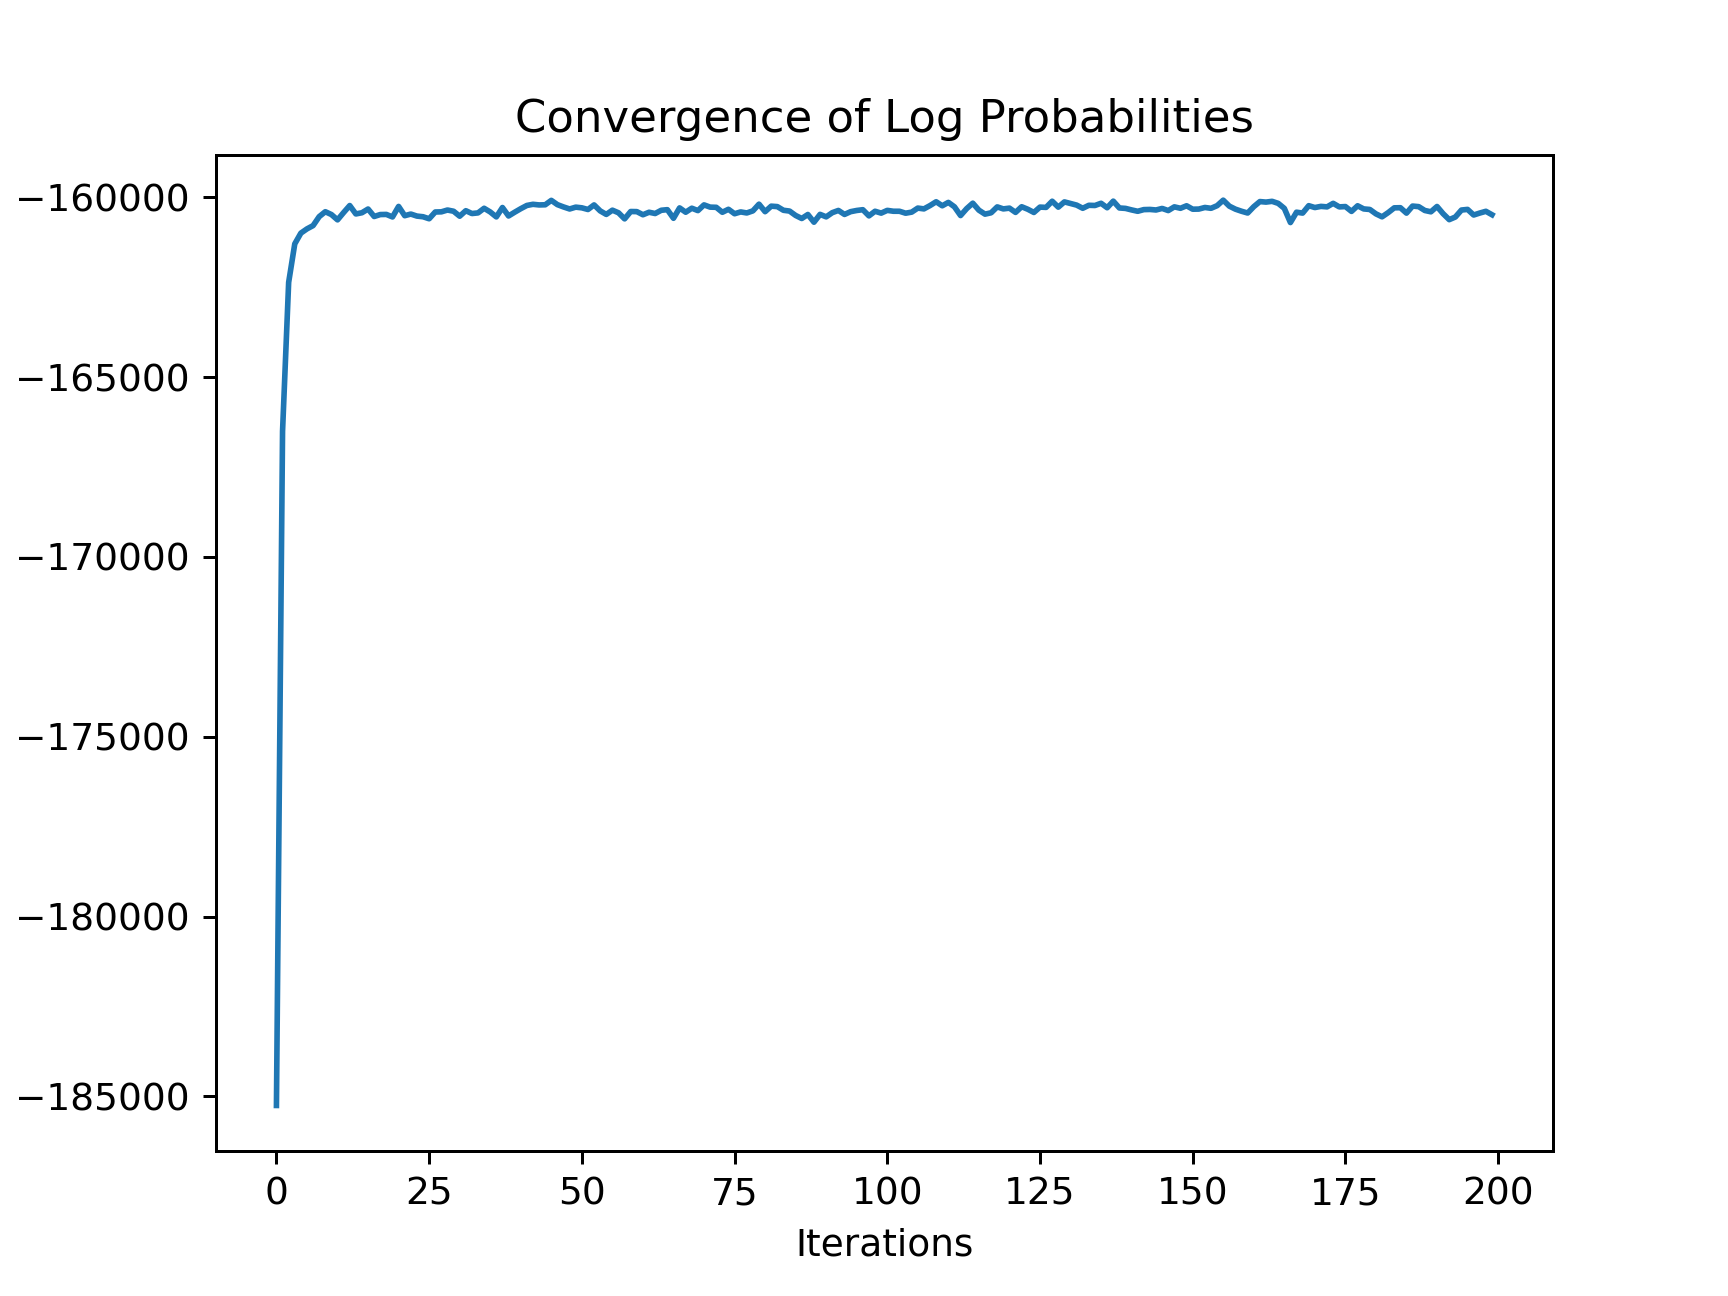

In [6]:
n_topics = 20
reagan = LDACGS(n_topics)
reagan.sample(filename='reagan.txt',stopwords_file='stopwords.txt') #specify filename, stopwords, all else is default

plt.plot(reagan.logprobs)
plt.title('Convergence of Log Probabilities')
plt.xlabel('Iterations')
plt.show()

#### It about 10 iterations

## Problem 7

Using the method `LDACGS.topterms()`, examine the topics for Reagan's addresses. 
If `n_topics=20` and `n_samples=10`, you should get the top $10$ words that represent each of the $20$ topics.
For each topic, decide what these ten words jointly represent, and come up with a label for them.

In [7]:
reagan.topterms() #now I will share my thoughts

[['--',
  'government',
  'people',
  'american',
  'federal',
  'america',
  'economic',
  'tax',
  'years',
  "we're"],
 ['drugs.',
  'music',
  'express',
  'music,',
  'universe',
  'pennsylvania',
  'silicon',
  'innovations',
  'hungry',
  'tough'],
 ['rising',
  '.',
  'setting',
  'sandinista',
  'plane',
  'sun',
  'painted',
  'door',
  'heroism',
  'victim.'],
 ['bills',
  'october',
  'weighing',
  'days,',
  '1st,',
  'tragedy',
  'unborn',
  'continuing',
  'resolution',
  'pounds.'],
 ['unborn',
  'depreciation',
  'born',
  'vehicles',
  'another,',
  'abortion',
  '"h."',
  'write-off',
  'children,',
  'reality'],
 ['heroism',
  'crash',
  'administered',
  'wounded',
  'aircraft,',
  'rescue',
  'employees,',
  'finest',
  'dedicated',
  'safety.'],
 ['"h."',
  'perfect',
  '"honorable"',
  'everyday',
  'launch',
  'around.',
  'justices',
  'prospects',
  'downpayment',
  'pleasure'],
 ['trevor',
  'requirements,',
  'finds',
  'package',
  'research,',
  'cheaper'

Concepts: american government, working class americans, american heroes, legislative agenda, the family, aviation, american gov't officials, academia, american finance, american labor, celebrating humble americans, impact of the gov't, trade, inflation, the constitution and political parties, fiscal policy, normative policy ideas, foreign policy, national security, american progress

In [8]:
#DONE